# Inteligencia Artificial
# Clase 19 - API Funcional de Keras

## ResNet50 con la API funcional de Keras

En esta notebook vamos a desarrollar el modelo residual ResNet50 usando la API funcional de Keras. 

Vamos a trabajar con el dataset CIFAR-10 que consta de 60000 imágenes en color de 32x32 partenecientes a 10 clases distintas, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de test.

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

Cargamos el dataset cifar 10 que está disponible con Keras e importamos Numpy:

In [0]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(train_images, train_labels), (test_images, test_labels)= cifar10.load_data()

170500096/170498071 [==============================] - 29s 0us/step


In [0]:
label_names = [
               'airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck'
]

Analizamos las dimensiones del dataset:

In [0]:
print ("Cantidad de observaciones en el set de entrenamiento: " + str(train_images.shape[0]))
print ("Cantidad de observaciones en el set de entrenamiento: " + str(test_images.shape[0]))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Cantidad de observaciones en el set de entrenamiento: 50000
Cantidad de observaciones en el set de entrenamiento: 10000
train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_images shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)


Para hacernos una mejor idea sobre los datos, hacemos un print de una de las imágenes y de su etiqueta:

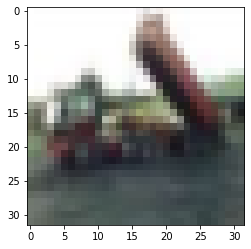

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.fromarray(train_images[2], 'RGB')
plt.imshow(img)

Vemos que la imagen, por más pixelada que esté, corresponde a un camión. Verifiquemos la etiqueta

In [0]:
label_names[train_labels[2][0]]

'truck'

Realizamos algunas tareas de preprocesamiento, normalizando las imágenes y transformando las etiquetas a one-hot-encoded:

In [0]:
from tensorflow.keras.utils import to_categorical

# Normalizamos:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Transformamos nuestras etiquetas multiclase en one hot:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [0]:
print ("train_labels shape: " + str(train_labels.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_labels shape: (50000, 10)
test_labels shape: (10000, 10)


In [0]:
train_labels[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

Importamos los módulos de Keras que nos van a servir para construir la ResNet50:

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform

## Identity block

Primero definimos el identity block, que es un módulo residual donde las dimensiones del X se mantienen a lo largo de las convoluciones y por lo tanto se puede sumar el shortcut directamente. El bloque que vamos a implementar es el que se ve en la imagen, con la diferencia de que nosotros estaremos incluyendo capas de normalización entre cada capa convolucional:

<img src=https://i.stack.imgur.com/37qzA.png>


In [0]:
def identity_block(X, f, filters, stage, block):
    
    # Definimos el nombre base
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Hacemos unpacking de los filtros
    F1, F2, F3 = filters
    
    # Guardamos el valor del input
    X_shortcut = X
    
    # Primer componente del main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1),
               padding = 'valid', name = conv_name_base + '2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Segundo componente del main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1),
               padding = 'same', name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Tercer componente del main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1),
               padding = 'valid', name = conv_name_base + '2c',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Último paso: sumamos el shortcut al main path y lo pasamos por una RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Convolutional block

Definimos ahora el bloque convolucional, en el cual hay que aplicar una convolución al shortcut para poderla sumar al main path.

<img src=https://i.stack.imgur.com/0mE2p.png>

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Definimos el nombre base
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Obtenemos los filtros
    F1, F2, F3 = filters

    # Guardamos el valor del input
    X_shortcut = X

    ##### MAIN PATH #####
    # Primer componente del main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s),
               padding='valid', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Segundo componente del main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1),
               padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Tercer componente del main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s),
                        padding='valid', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Último paso: sumamos el shortcut al main path, y lo pasamos por una RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## Construimos el modelo ResNet50

Podemos ver la arquitectura completa desde este [link](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)

In [0]:
def ResNet50(input_shape = (32, 32, 3), classes = 6):
    
    # Definimos el input como un tensor con shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Instanciamos el modelo
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [0]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

Recordemos que a diferencia de los modelos secuenciales, cada capa no necesariamente está conectada con la anterior, pudiendo estar conectada con varias capas a la vez tanto en la entrada como en la salida. Para explicitar estas conexiones arbitrarias que no se limitan a la secuencialidad, el `summary` incluye una columna **connected to** que indica las conexiones de cada capa.

Compilamos el modelo:

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo. Como esta es una práctica con fines demostrativos, vamos a entrenar el modelo desde 0 por 20 epochs:

In [0]:
history = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 21s 69ms/step - loss: 2.3713 - accuracy: 0.2799 - val_loss: 46.9447 - val_accuracy: 0.1317
Epoch 2/20
313/313 [==============================] - 21s 67ms/step - loss: 1.7925 - accuracy: 0.4243 - val_loss: 10.2268 - val_accuracy: 0.3424
Epoch 3/20
313/313 [==============================] - 21s 65ms/step - loss: 1.6550 - accuracy: 0.4764 - val_loss: 2.9015 - val_accuracy: 0.1563
Epoch 4/20
313/313 [==============================] - 21s 66ms/step - loss: 1.6190 - accuracy: 0.5045 - val_loss: 2.8364 - val_accuracy: 0.2630
Epoch 5/20
313/313 [==============================] - 21s 66ms/step - loss: 1.4552 - accuracy: 0.5492 - val_loss: 7.0623 - val_accuracy: 0.3331
Epoch 6/20
313/313 [==============================] - 21s 66ms/step - loss: 1.3475 - accuracy: 0.5761 - val_loss: 2.0590 - val_accuracy: 0.4996
Epoch 7/20
313/313 [==============================] - 21s 67ms/step - loss: 1.1518 - accuracy: 0.6197 - val_loss: 1.5010 - val_accurac

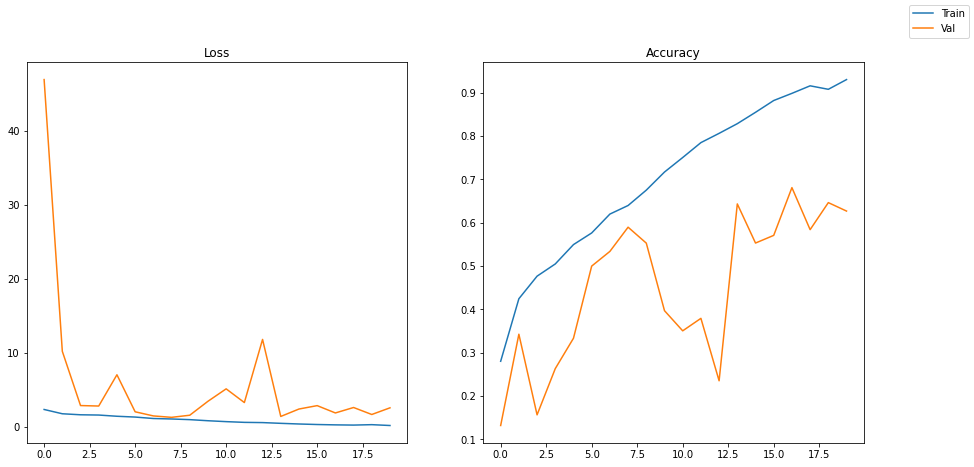

In [0]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss')
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy')
fig.legend(['Train', 'Val'])

Evaluamos los resultados en el set de testeo:

In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 11ms/step - loss: 2.6676 - accuracy: 0.6201


In [0]:
test_acc

0.6201000213623047